In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os

import bin2cell_demo as b2c

#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

coordinate_utils.py loaded
image_utils.py loaded
stardist_utils.py loaded
data_utils.py loaded
visualization_utils.py loaded


In [2]:
path = "binned_outputs/square_002um/"
#the image you used for --image of spaceranger, that's the one the spatial coordinates are based on
source_image_path = "Visium_HD_Mouse_Brain_tissue_image.tif"
spaceranger_image_path = "binned_outputs/square_002um/spatial"
from pathlib import Path
print("Source image path:", Path(source_image_path).resolve())
print("Spaceranger image path:", Path(spaceranger_image_path).resolve())


Source image path: D:\bin2cell_demo\Visium_HD_Mouse_Brain_tissue_image.tif
Spaceranger image path: D:\bin2cell_demo\binned_outputs\square_002um\spatial


In [3]:
adata = b2c.read_visium(path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )

adata.var_names_make_unique()
adata

anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1756): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 6132629 × 18823
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
mpp = 0.5

b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


In [6]:
b2c.destripe(adata)

_construct.py (149): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
... storing 'feature_types' as categorical
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
... storing 'genome' as categorical


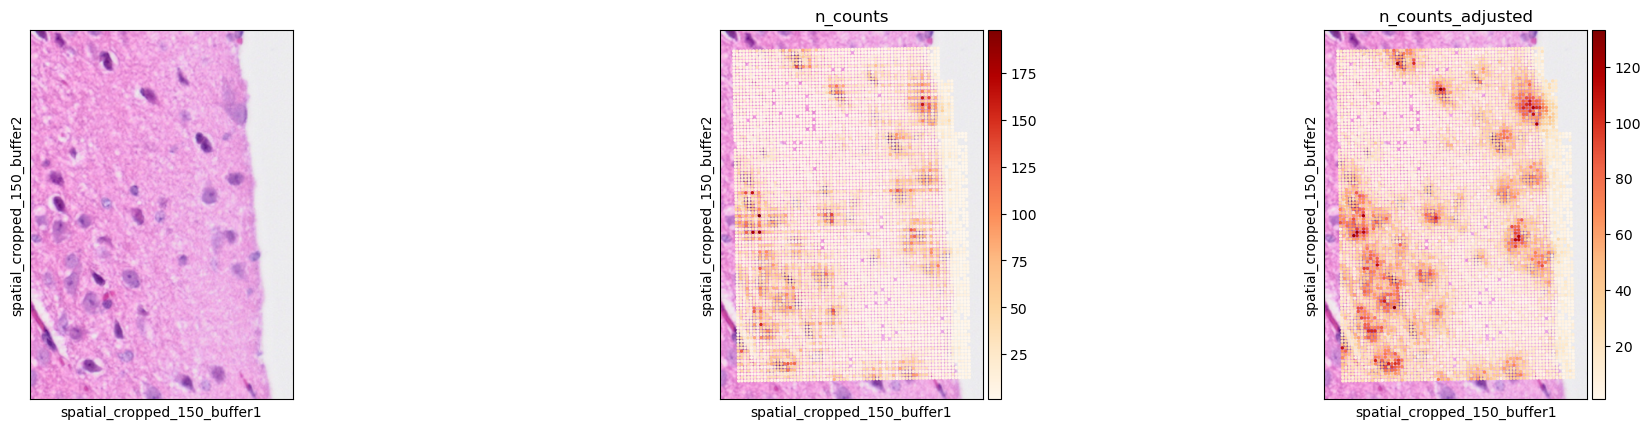

In [7]:
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 250) & 
        (adata.obs['array_col'] <= 450)
       )

bdata = adata[mask]
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd",
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

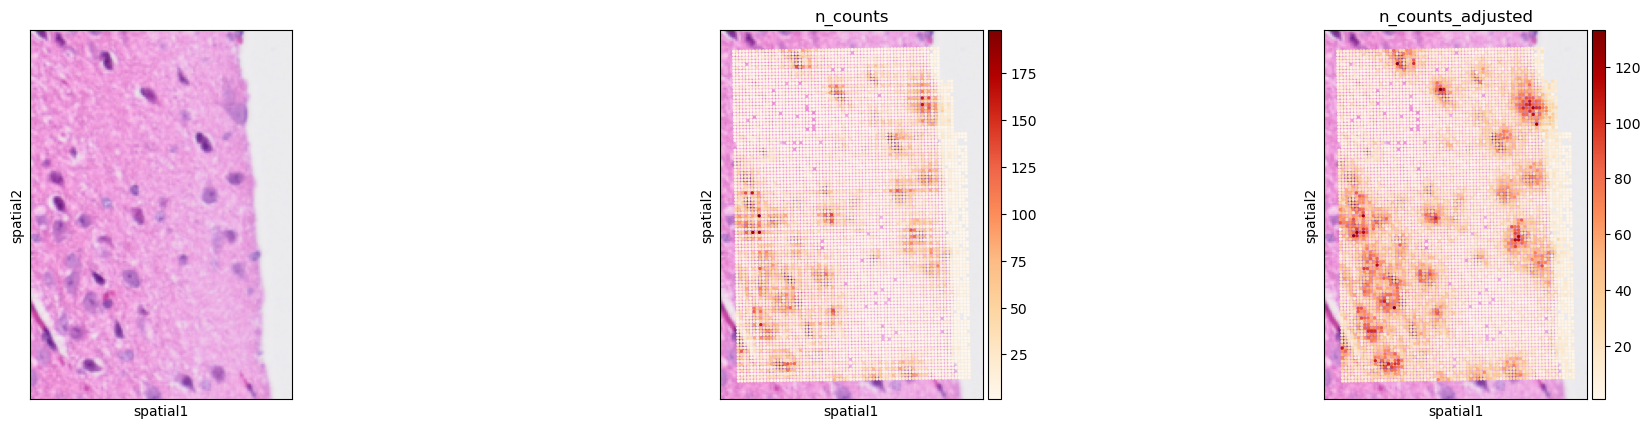

In [8]:
sc.pl.spatial(bdata, color=[None, "n_counts", "n_counts_adjusted"], color_map="OrRd")

In [9]:
b2c.stardist(image_path="stardist/he.tiff", 
             labels_npz_path="stardist/he.npz", 
             stardist_model="2D_versatile_he", 
             prob_thresh=0.01
            )

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:44<00:00, 28.71s/it]


Found 61984 objects


In [10]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/he.npz", 
                  basis="spatial", 
                  spatial_key="spatial_cropped_150_buffer",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

3610035367.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'labels_he' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


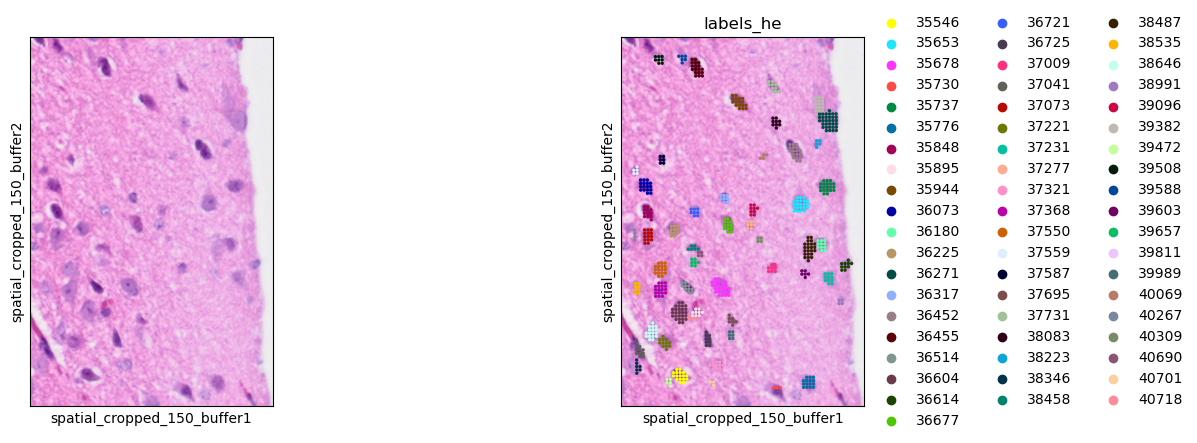

In [11]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

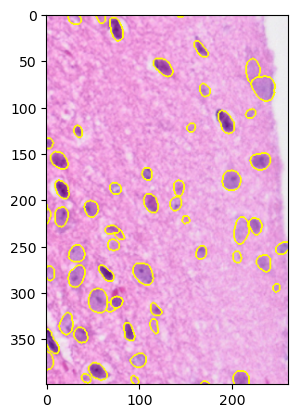

In [12]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="spatial", spatial_key="spatial_cropped_150_buffer", mpp=mpp)

rendered = b2c.view_labels(image_path="stardist/he.tiff", 
                           labels_npz_path="stardist/he.npz", 
                           crop=crop
                          )
plt.imshow(rendered)

In [13]:
b2c.expand_labels(adata, 
                  labels_key='labels_he', 
                  expanded_labels_key="labels_he_expanded"
                 )

1371630977.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'labels_he_expanded' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


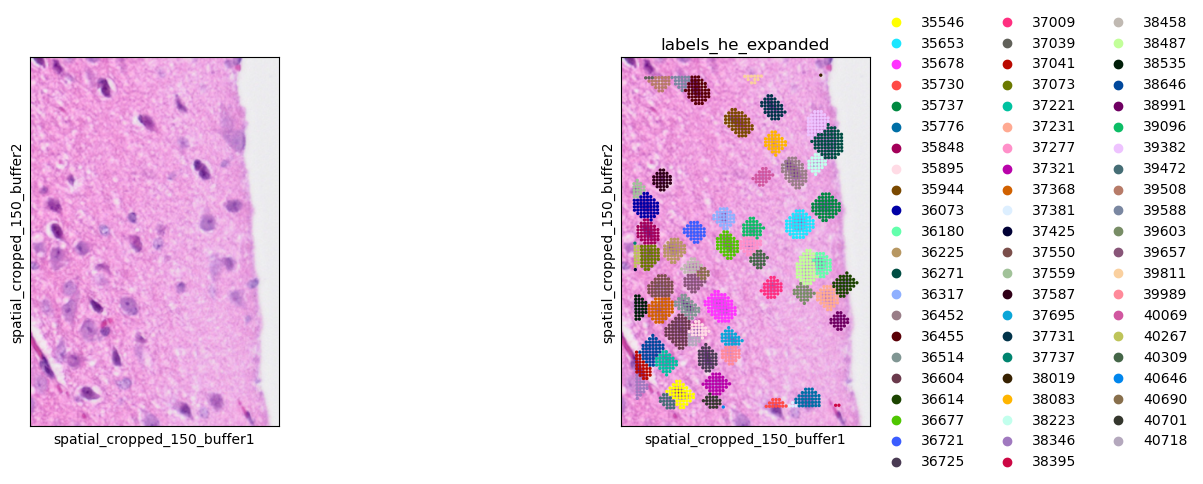

In [14]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_he_expanded']>0]
bdata.obs['labels_he_expanded'] = bdata.obs['labels_he_expanded'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he_expanded"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

In [15]:
b2c.grid_image(adata, "n_counts_adjusted", mpp=mpp, sigma=5, save_path="stardist/gex.tiff")

In [16]:
b2c.stardist(image_path="stardist/gex.tiff", 
             labels_npz_path="stardist/gex.npz", 
             stardist_model="2D_versatile_fluo", 
             prob_thresh=0.05, 
             nms_thresh=0.5
            )

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [10:01<00:00, 37.59s/it]


Found 50576 objects


In [17]:
b2c.insert_labels(adata, 
                  labels_npz_path="stardist/gex.npz", 
                  basis="array", 
                  mpp=mpp, 
                  labels_key="labels_gex"
                 )

1941188598.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'labels_gex' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


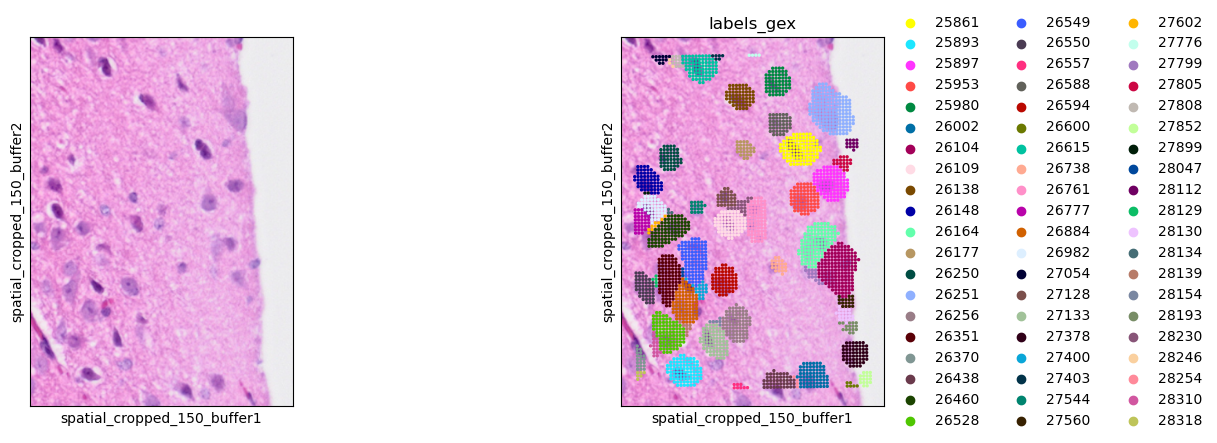

In [18]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_gex']>0]
bdata.obs['labels_gex'] = bdata.obs['labels_gex'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_gex"], img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

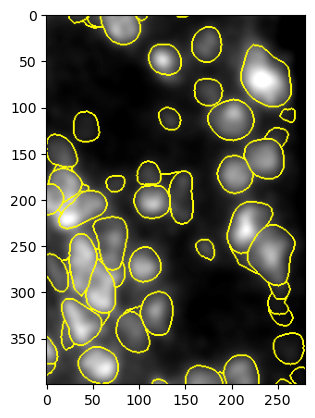

In [19]:
#the label viewer wants a crop of the processed image
#get the corresponding coordinates spanning the subset object
crop = b2c.get_crop(bdata, basis="array", mpp=mpp)

#GEX pops better with percentile normalisation performed
rendered = b2c.view_labels(image_path="stardist/gex.tiff", 
                           labels_npz_path="stardist/gex.npz", 
                           crop=crop,
                           stardist_normalize=True
                          )
plt.imshow(rendered)

In [20]:
b2c.salvage_secondary_labels(adata, 
                             primary_label="labels_he_expanded", 
                             secondary_label="labels_gex", 
                             labels_key="labels_joint"
                            )

Salvaged 8060 secondary labels


186021875.py (5): Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'labels_joint' as categorical
... storing 'labels_joint_source' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


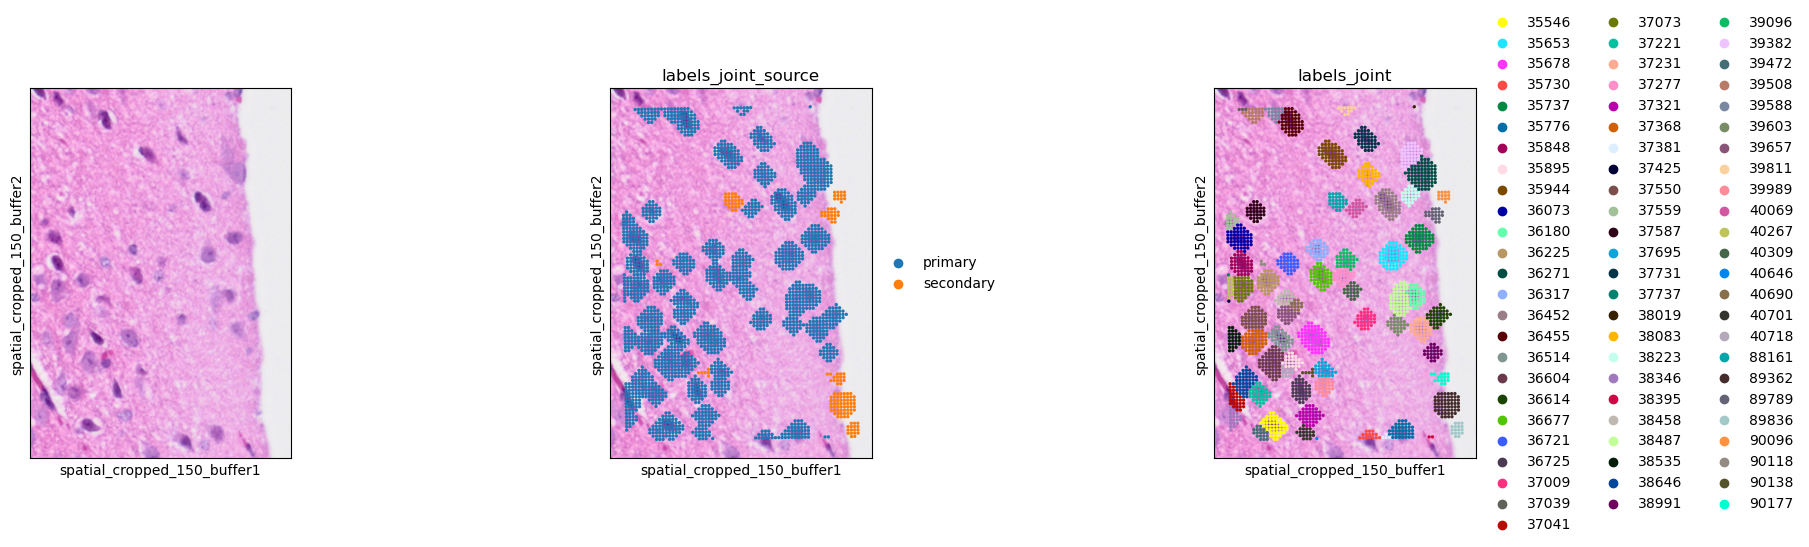

In [21]:
bdata = adata[mask]

#the labels obs are integers, 0 means unassigned
bdata = bdata[bdata.obs['labels_joint']>0]
bdata.obs['labels_joint'] = bdata.obs['labels_joint'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_joint_source", "labels_joint"], 
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")

In [22]:
cdata = b2c.bin_to_cell(adata, labels_key="labels_joint", spatial_keys=["spatial", "spatial_cropped_150_buffer"])

anndata.py (1145): Trying to modify attribute `.obs` of view, initializing view as actual.
... storing 'labels_joint_source' as categorical
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
... storing 'feature_types' as categorical
anndata.py (1145): Trying to modify attribute `.var` of view, initializing view as actual.
... storing 'genome' as categorical


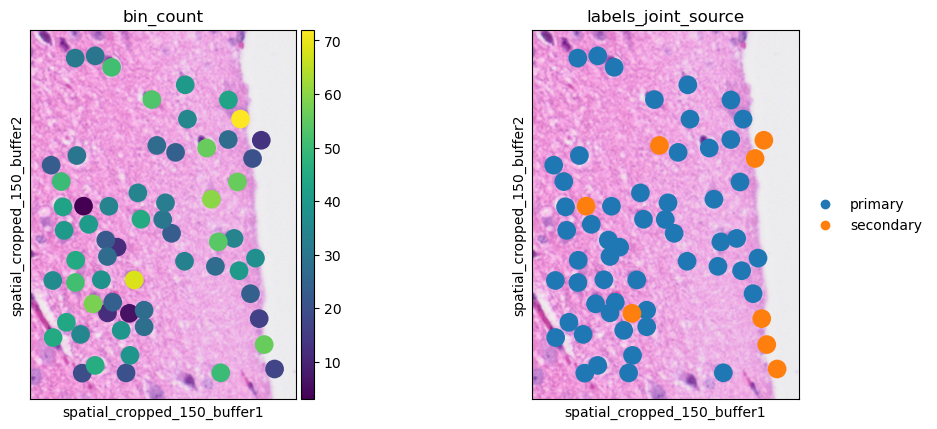

In [23]:
cell_mask = ((cdata.obs['array_row'] >= 1450) & 
             (cdata.obs['array_row'] <= 1550) & 
             (cdata.obs['array_col'] >= 250) & 
             (cdata.obs['array_col'] <= 450)
            )

ddata = cdata[cell_mask]
sc.pl.spatial(ddata, color=["bin_count", "labels_joint_source"], 
              img_key="0.5_mpp_150_buffer", basis="spatial_cropped_150_buffer")